In [1]:
import torch as th
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

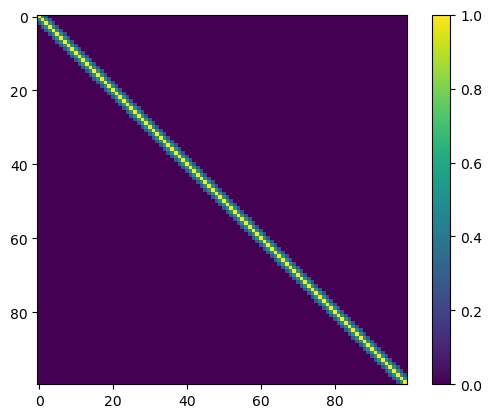

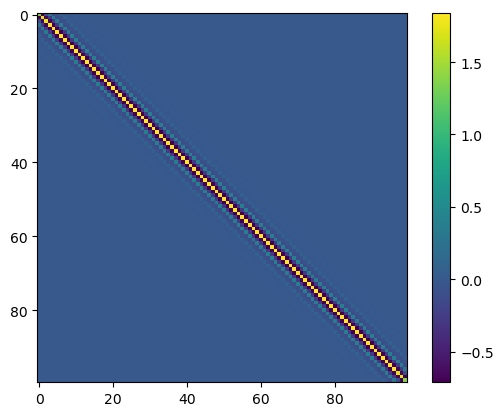

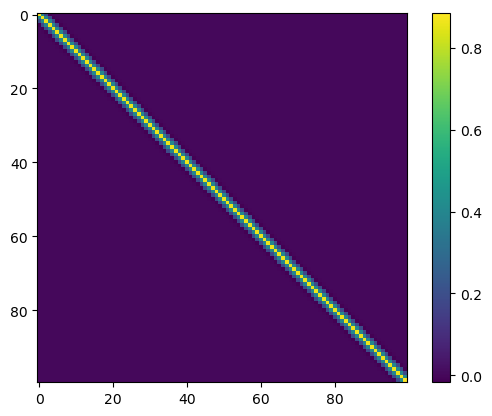

In [2]:
# create a GMRF with banded precision matrix
N = 100
precision_matrix = th.zeros(N, N)
# Set main diagonal to 1.0
precision_matrix.diagonal().fill_(1.0)
# Set first diagonal above and below the main diagonal to -0.5
precision_matrix.diagonal(offset=1).fill_(0.5)
precision_matrix.diagonal(offset=-1).fill_(0.5)
precision_matrix.diagonal(offset=2).fill_(0.25)
precision_matrix.diagonal(offset=-2).fill_(0.25)
plt.imshow(precision_matrix)
plt.colorbar()
plt.show()
cov = th.linalg.inv(precision_matrix)
plt.imshow(cov)
plt.colorbar()
plt.show()
# add noise to the GMRF
sigma2 = 0.1
cov_noise = sigma2 * th.eye(N) + cov 
precision_matrix_noise = th.linalg.inv(cov_noise)
plt.imshow(precision_matrix_noise)
plt.colorbar()
plt.show()
# compute the precision matrix
# plot the banded structure
# compute the covariance matrix

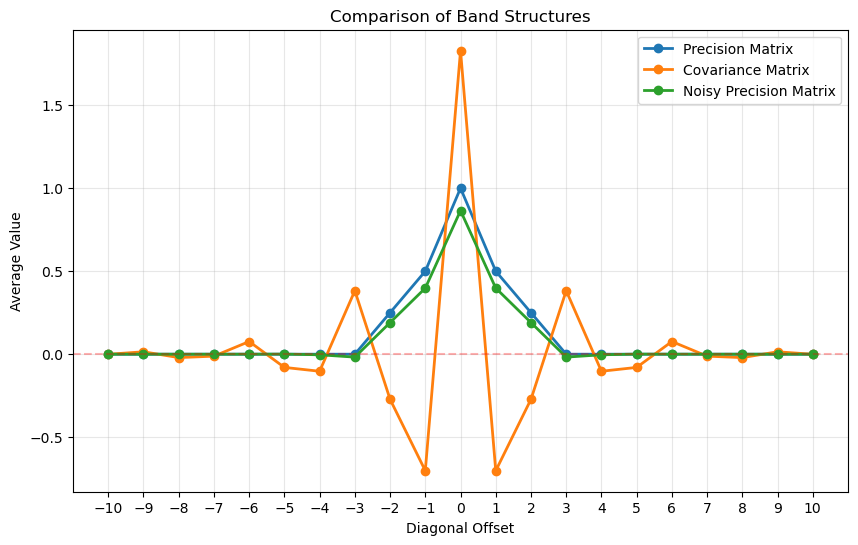

In [3]:
def compute_band_structure(matrix, max_offset=10):
    """
    Compute the average diagonal value as a function of offset for a banded matrix.
    
    Args:
        matrix: A square matrix (torch tensor or numpy array)
        max_offset: Maximum offset to compute
        
    Returns:
        tuple: (offsets, avg_values) where offsets is the range of diagonal offsets
               and avg_values are the corresponding average values
    """
    if isinstance(matrix, torch.Tensor):
        matrix = matrix.numpy()
    
    offsets = range(-max_offset, max_offset + 1)
    avg_values = []
    
    for offset in offsets:
        diag_values = np.diagonal(matrix, offset=offset)
        avg_values.append(np.mean(diag_values))
    
    return offsets, avg_values


def plot_band_structure(matrices, labels, max_offset=10, title="Band Structure Comparison", normalize=False):
    """
    Plot the average diagonal value as a function of offset for multiple matrices on the same plot.
    
    Args:
        matrices: List of square matrices (torch tensor or numpy array)
        labels: List of labels for each matrix
        max_offset: Maximum offset to plot
        title: Title for the plot
        normalize: If True, normalize values by dividing by the maximum value
        
    Returns:
        matplotlib.pyplot: The plot object
    """
    plt.figure(figsize=(10, 6))
    
    for matrix, label in zip(matrices, labels):
        offsets, avg_values = compute_band_structure(matrix, max_offset)
        
        if normalize:
            max_value = max(abs(v) for v in avg_values)
            if max_value != 0:  # Avoid division by zero
                avg_values = [v / max_value for v in avg_values]
                ylabel = "Normalized Average Value"
            else:
                ylabel = "Average Value"
        else:
            ylabel = "Average Value"
            
        plt.plot(offsets, avg_values, 'o-', linewidth=2, label=label)
    
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Diagonal Offset')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(list(range(-max_offset, max_offset + 1)))
    plt.legend()
    return plt

# Plot band structure for all matrices together
matrices = [precision_matrix, cov, precision_matrix_noise]
labels = ["Precision Matrix", "Covariance Matrix", "Noisy Precision Matrix"]
plot_band_structure(matrices, labels, title="Comparison of Band Structures")
plt.show()


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


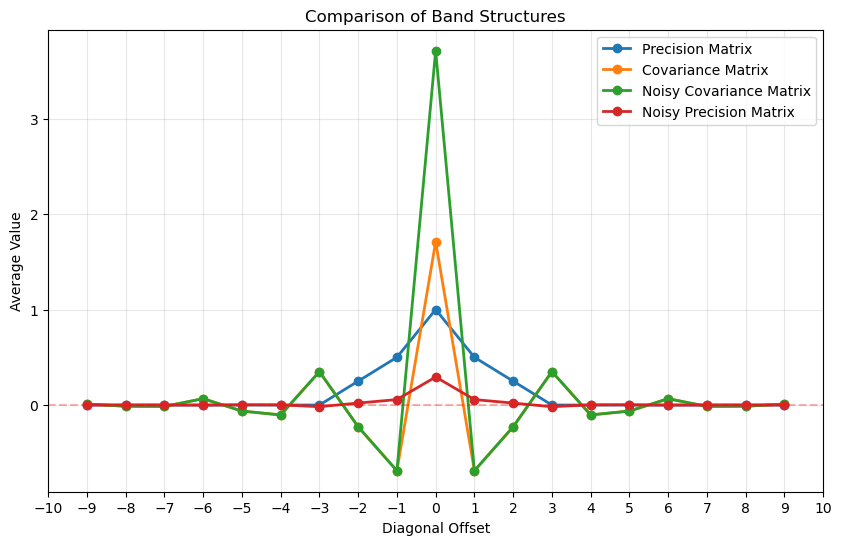

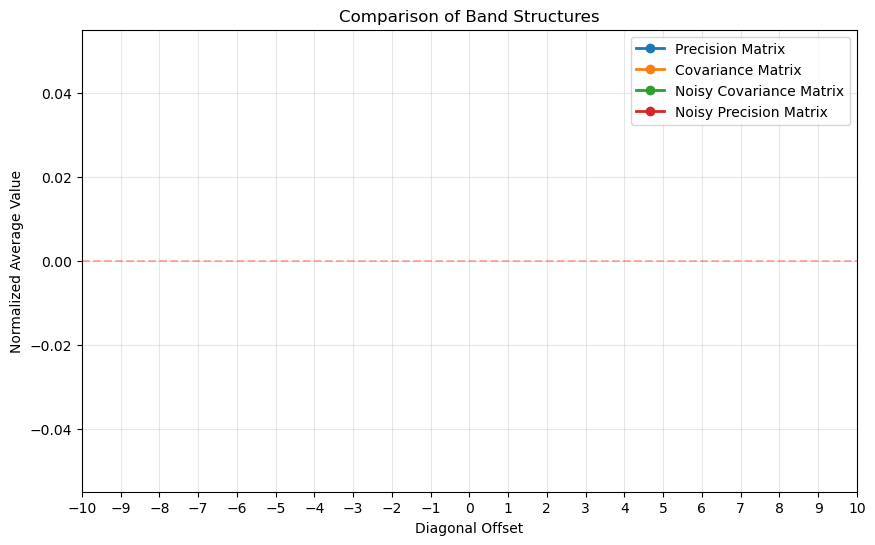

In [4]:
# create a GMRF with banded precision matrix
N = 10
precision_matrix = th.zeros(N, N)
# Set main diagonal to 1.0
precision_matrix.diagonal().fill_(1.0)
# Set first diagonal above and below the main diagonal to -0.5
precision_matrix.diagonal(offset=1).fill_(0.5)
precision_matrix.diagonal(offset=-1).fill_(0.5)
precision_matrix.diagonal(offset=2).fill_(0.25)
precision_matrix.diagonal(offset=-2).fill_(0.25)
cov = th.linalg.inv(precision_matrix)
# add noise to the GMRF
sigma2 = 2
cov_noise = sigma2 * th.eye(N) + cov 
precision_matrix_noise = th.linalg.inv(cov_noise)
matrices = [precision_matrix, cov, cov_noise, precision_matrix_noise]
labels = ["Precision Matrix", "Covariance Matrix", "Noisy Covariance Matrix", "Noisy Precision Matrix"]
plot_band_structure(matrices, labels, title="Comparison of Band Structures")
plt.show()
plot_band_structure(matrices, labels, title="Comparison of Band Structures", normalize=True)
plt.show()


### Convolutional denoiser 

In [5]:
# Create a random covariance matrix
# First, create a random matrix
N = 200  # Size of the matrix
np.random.seed(42)  # For reproducibility

# Method 1: Creating a covariance matrix with power spectrum structure
# Create a distance matrix
indices = np.arange(N)
distances = np.abs(indices[:, np.newaxis] - indices[np.newaxis, :])
# Create power-law decay (1/f^alpha structure)
alpha = 1.5  # Power spectrum exponent
symm_cov_mat = 1.0 / (1.0 + distances)**alpha
# Add small noise to avoid perfect symmetry
symm_cov_mat += 0.15 * np.random.randn(N, N)
# Ensure symmetry
symm_cov_mat = 0.5 * (symm_cov_mat + symm_cov_mat.T)
symm_cov_tsr = th.tensor(symm_cov_mat, dtype=th.float32)
# Ensure positive definiteness by adding a small value to the diagonal
# random_cov = symmetric_matrix + N * np.eye(N)

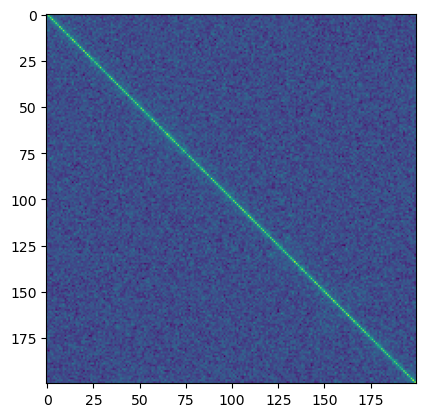

In [6]:
plt.imshow(symm_cov_mat)

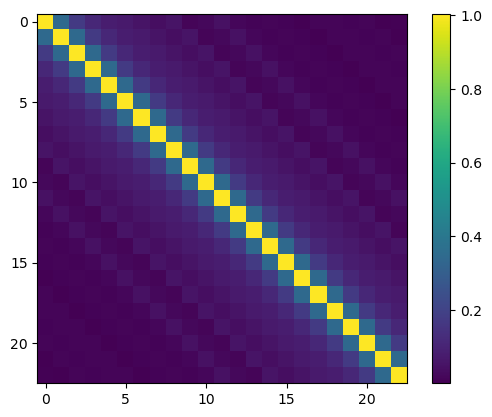

In [9]:
K = 11
offsets = th.arange(-K, K+1)
avg_cov_diag = th.zeros(2*K+1)
for k in range(-K, K+1):
    avg_cov_diag[k+K] = th.mean(th.diag(symm_cov_tsr, diagonal=k))

patch_circ_cov = th.zeros(2 * K + 1, 2 * K + 1)
for k in range(-K, K+1):
    for j in range(-K, K+1):
        patch_circ_cov[k+K, j+K] = th.mean(th.diag(symm_cov_tsr, diagonal=j - k)) #avg_cov_diag[j - k + K]
plt.imshow(patch_circ_cov)
plt.colorbar()
plt.show()

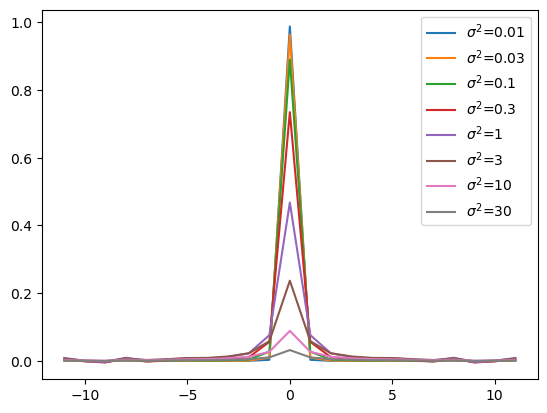

In [10]:
sigma2 = 0.01
for sigma2 in [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]:
    conv_weight_ols = th.linalg.solve(patch_circ_cov + sigma2 * th.eye(2 * K + 1), avg_cov_diag)
    plt.plot(offsets, conv_weight_ols, label=f'$\sigma^2$={sigma2}')
# plt.yscale('log')
plt.legend()
plt.show()

In [11]:
# Display the original conv_weight_ols
# conv_weight_ols
conv_weight_pad = th.zeros(N,)
conv_weight_pad[:2*K+1,] = conv_weight_ols
conv_weight_pad_shifted = th.roll(conv_weight_pad, shifts=-K)
# Compute FFT of the shifted weights
DFT_conv_weight = th.fft.fft(conv_weight_pad_shifted, n=N)
# assert imaginary part is close to 0
assert th.sum(th.imag(DFT_conv_weight)) < 1e-6

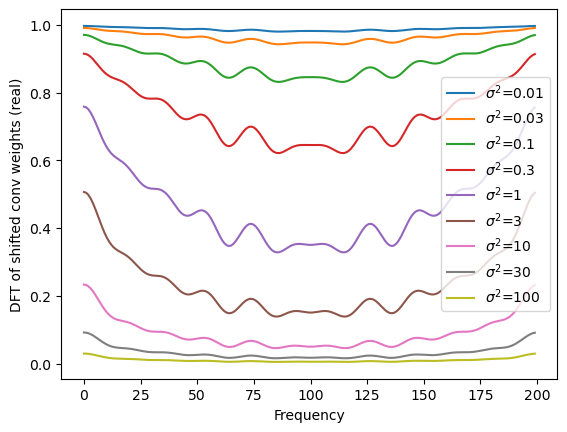

In [12]:
sigma2 = 0.01
for sigma2 in [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]:
    conv_weight_ols = th.linalg.solve(patch_circ_cov + sigma2 * th.eye(2 * K + 1), avg_cov_diag)
    conv_weight_pad = th.zeros(N,)
    conv_weight_pad[:2*K+1,] = conv_weight_ols
    conv_weight_pad_shifted = th.roll(conv_weight_pad, shifts=-K)
    DFT_conv_weight = th.fft.fft(conv_weight_pad_shifted, n=N)
    plt.plot(th.real(DFT_conv_weight), label=f'$\sigma^2$={sigma2}')
# plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('DFT of shifted conv weights (real)')
plt.legend()
plt.show()



In [13]:
sigma2 = 0.01
DFT_conv_weight_col = []
sigma2_list = np.logspace(np.log10(0.001), np.log10(100), 500)
for sigma2 in sigma2_list:
    conv_weight_ols = th.linalg.solve(patch_circ_cov + sigma2 * th.eye(2 * K + 1), avg_cov_diag)
    conv_weight_pad = th.zeros(N,)
    conv_weight_pad[:2*K+1,] = conv_weight_ols
    conv_weight_pad_shifted = th.roll(conv_weight_pad, shifts=-K)
    DFT_conv_weight = th.fft.fft(conv_weight_pad_shifted, n=N)
    DFT_conv_weight_col.append(th.real(DFT_conv_weight))
DFT_conv_weight_tsr = th.stack(DFT_conv_weight_col, dim=0)

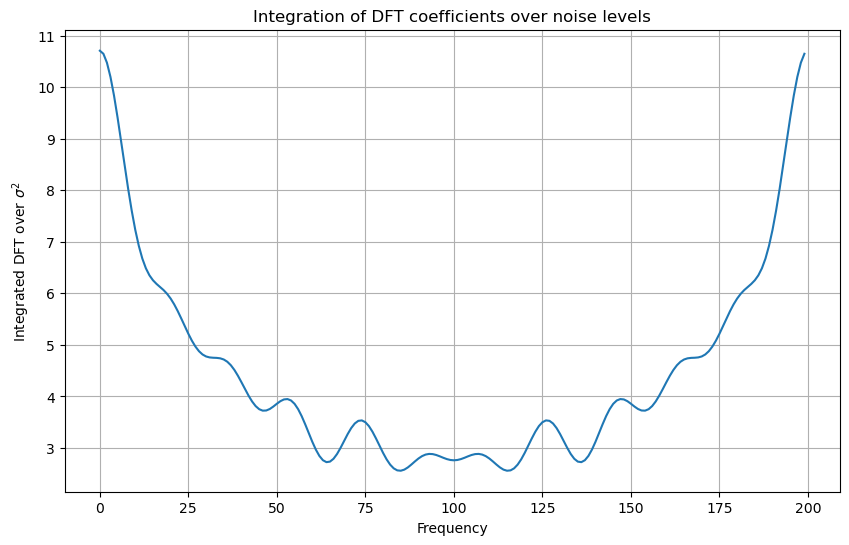

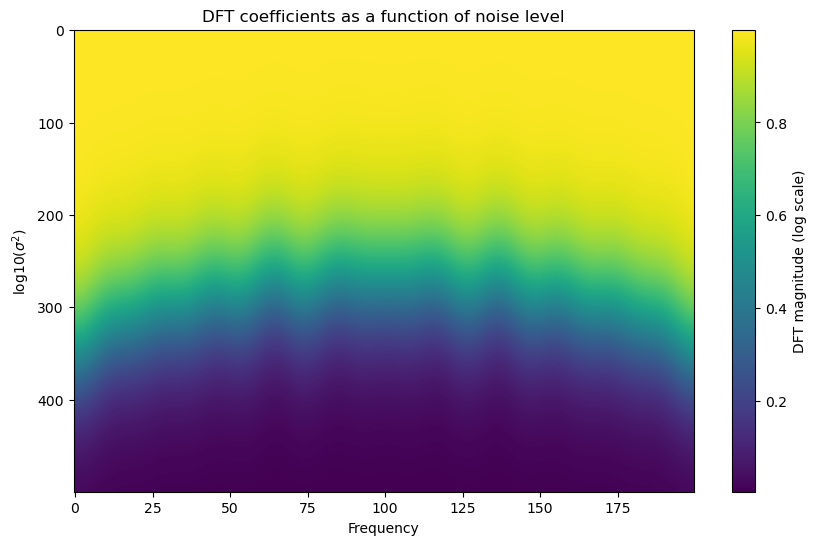

In [14]:
import matplotlib.colors
# integrate over DFT over sigma2
# To integrate DFT_conv_weight_tsr over sigma2_list, we need to:
# 1. Define the integration range (sigma2_list)
# 2. Calculate the width of each interval (for numerical integration)
# 3. Sum the function values multiplied by the interval widths

# Since sigma2_list is logarithmically spaced, we can use the trapezoid rule
# which is more elegant and accurate for numerical integration
integrated_DFT = th.trapz(DFT_conv_weight_tsr, th.tensor(sigma2_list), dim=0)

# Plot the integrated DFT
plt.figure(figsize=(10, 6))
plt.plot(integrated_DFT)
plt.xlabel('Frequency')
plt.ylabel('Integrated DFT over $\sigma^2$')
plt.title('Integration of DFT coefficients over noise levels')
plt.grid(True)
plt.show()

# We can also visualize how the DFT evolves with sigma2
plt.figure(figsize=(10, 6))
plt.imshow(DFT_conv_weight_tsr.numpy(), aspect='auto', cmap='viridis')
        #    extent=(0, N-1, np.log10(sigma2_list[-1]), np.log10(sigma2_list[0])),
        #    norm=matplotlib.colors.LogNorm())
plt.colorbar(label='DFT magnitude (log scale)')
plt.xlabel('Frequency')
plt.ylabel('log10($\sigma^2$)')
plt.title('DFT coefficients as a function of noise level')
plt.show()

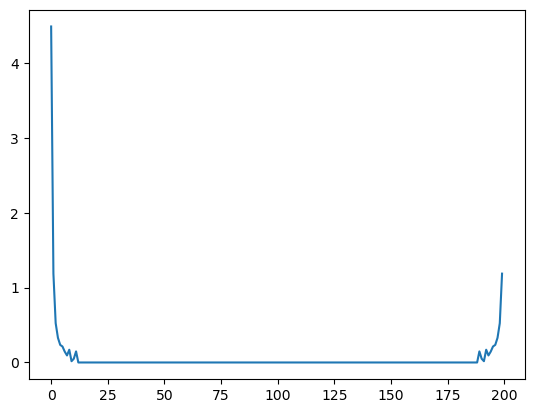

Number of non-zero elements in cov_values: 23
Value of 2K+1: 23


In [15]:
cov_values = th.fft.ifft(integrated_DFT, n=N).real
plt.plot(cov_values)
plt.show()
# Count how many values in cov_values are not close to zero
# Define a threshold for what we consider "close to zero"
threshold = 1e-7
non_zero_count = (th.abs(cov_values) > threshold).sum().item()

# Compare with 2K+1
print(f"Number of non-zero elements in cov_values: {non_zero_count}")
print(f"Value of 2K+1: {2*K+1}")
# print(f"Ratio of non-zero elements to 2K+1: {non_zero_count/(2*K+1):.4f}")

# # Visualize the significant values
# plt.figure(figsize=(10, 6))
# plt.stem(th.arange(len(cov_values)), th.abs(cov_values))
# plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
# plt.xlabel('Index')
# plt.ylabel('Absolute value')
# plt.title('Significant values in cov_values')
# plt.yscale('log')
# plt.legend()
# plt.grid(True)
# plt.show()

In [16]:
cov_values

tensor([ 4.4861e+00,  1.1863e+00,  5.2426e-01,  3.2919e-01,  2.3482e-01,
         2.1333e-01,  1.4505e-01,  9.3931e-02,  1.7024e-01,  1.6991e-02,
         5.0017e-02,  1.4785e-01,  1.1474e-09, -2.2615e-09,  7.9266e-10,
        -1.6518e-09,  7.1328e-10, -2.3829e-09, -6.2620e-09, -1.5078e-09,
         1.4682e-09, -1.1148e-09,  7.6232e-10, -5.0666e-09, -2.7755e-09,
        -3.5639e-09, -1.8969e-09, -6.4265e-09,  6.6594e-10, -6.6484e-09,
        -3.3834e-09, -1.0373e-08, -5.8960e-10, -1.8673e-09,  1.8910e-09,
         2.6900e-10, -7.9080e-10, -2.7143e-10,  1.1667e-09, -2.4215e-09,
         8.7264e-10,  6.1337e-09,  1.5615e-09,  6.0710e-09,  1.1938e-09,
         6.4056e-09,  2.2568e-09,  5.0336e-09,  1.5025e-09,  7.3418e-09,
         9.7893e-10, -4.5302e-11, -4.3406e-11, -4.5810e-09, -7.0708e-10,
         4.6223e-10, -3.4800e-09, -4.0767e-09, -1.4628e-09, -3.5641e-10,
        -1.0027e-09, -2.4434e-09,  7.0848e-10, -3.6111e-10, -1.1341e-09,
        -2.1160e-09, -8.9515e-10, -3.5529e-09,  5.7

In [ ]:
K = 15
offsets = th.arange(-K, K+1)
avg_cov_diag = th.zeros(2*K+1)
for k in range(-K, K+1):
    avg_cov_diag[k+K] = th.mean(th.diag(symm_cov_tsr, diagonal=k))

patch_circ_cov = th.zeros(2 * K + 1, 2 * K + 1)
for k in range(-K, K+1):
    for j in range(-K, K+1):
        patch_circ_cov[k+K, j+K] = th.mean(th.diag(symm_cov_tsr, diagonal=j - k)) #avg_cov_diag[j - k + K]


DFT_conv_weight_col = []
sigma_list = np.logspace(np.log10(0.001), np.log10(100), 1000)
for sigma in sigma_list:
    conv_weight_ols = th.linalg.solve(patch_circ_cov + sigma ** 2 * th.eye(2 * K + 1), avg_cov_diag)
    conv_weight_pad = th.zeros(N,)
    conv_weight_pad[:2*K+1,] = conv_weight_ols
    conv_weight_pad_shifted = th.roll(conv_weight_pad, shifts=-K)
    DFT_conv_weight = th.fft.fft(conv_weight_pad_shifted, n=N)
    DFT_conv_weight_col.append(th.real(DFT_conv_weight))
DFT_conv_weight_tsr = th.stack(DFT_conv_weight_col, dim=0)
sigma_tsr = th.tensor(sigma_list, dtype=th.float32)
integrated_DFT = th.trapz(DFT_conv_weight_tsr, sigma_tsr, dim=0)
integrated_amplif = th.trapz(- (1 - DFT_conv_weight_tsr) / sigma_tsr[:, None], sigma_tsr, dim=0)

cov_values = th.fft.ifft(integrated_DFT, n=N).real
# Count how many values in cov_values are not close to zero
# Define a threshold for what we consider "close to zero"
threshold = 1e-7
non_zero_count = (th.abs(cov_values) > threshold).sum().item()
# Compare with 2K+1
print(f"Number of non-zero elements in cov_values: {non_zero_count}")
print(f"Value of 2K+1: {2*K+1}")

cov_values = th.fft.ifft(integrated_amplif.exp(), n=N).real
threshold = 1e-7
non_zero_count = (th.abs(cov_values) > threshold).sum().item()
# Compare with 2K+1
print(f"Number of non-zero elements in cov_values: {non_zero_count}")
print(f"Value of 2K+1: {2*K+1}")

Number of non-zero elements in cov_values: 31
Value of 2K+1: 31


Number of non-zero elements in cov_values: 57
Value of 2K+1: 31


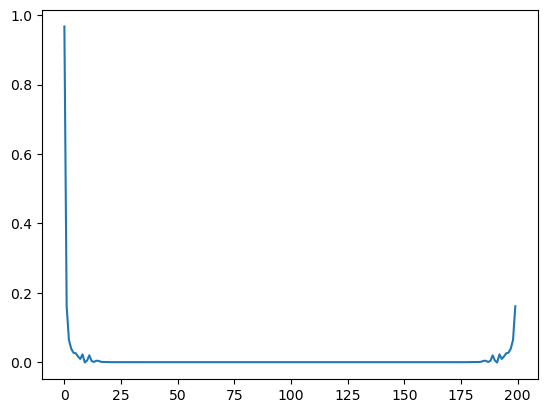

In [38]:
plt.plot(100 * cov_values)

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/_tensor.py:1089: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


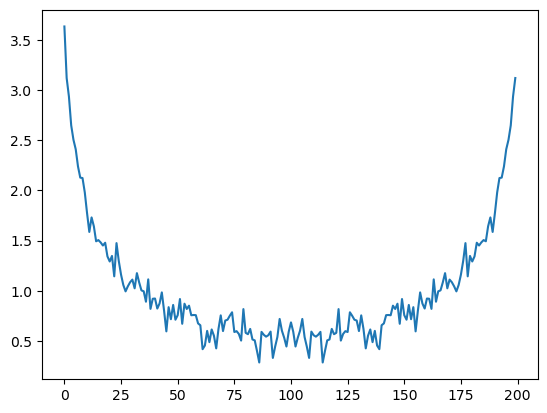

In [27]:
import torch

def cov_to_fourier(cov: torch.Tensor, unitary: bool = True) -> torch.Tensor:
    """
    Convert a covariance matrix to the Fourier domain via F cov F^* using PyTorch.

    Parameters
    ----------
    cov : torch.Tensor
        An (N, N) real or complex covariance matrix.
    unitary : bool
        Whether to use unitary ('ortho') normalization for the Fourier transform.

    Returns
    -------
    torch.Tensor
        The covariance matrix in the Fourier domain (complex tensor).
    """
    # Ensure square matrix
    N = cov.size(0)
    assert cov.size(1) == N, "Covariance matrix must be square (N x N)"

    # Prepare identity on same device & dtype
    device = cov.device
    dtype = cov.dtype
    identity = torch.eye(N, dtype=dtype, device=device)

    # Perform DFT of identity to get Fourier matrix
    norm_mode = 'ortho' if unitary else None
    F = torch.fft.fft(identity, dim=0, norm=norm_mode)

    # Compute F cov F^*
    cov_fft = F @ cov.to(torch.complex64) @ torch.conj(F).transpose(-2, -1)
    return cov_fft

# Transform symm_cov_tsr to Fourier basis
# Transform covariance matrix to Fourier domain using F Σ F*
# For a circulant covariance matrix, this is equivalent to:
# 1. Compute the 2D FFT of the covariance matrix
# 2. The result represents the eigenvalues of the covariance matrix in the Fourier basis
symm_cov_fft = cov_to_fourier(symm_cov_tsr)  # F Σ F* where F is the Fourier transform matrix
# Extract diagonal values from the Fourier transform
symm_cov_fft_diag = th.diagonal(symm_cov_fft)
# Display the diagonal values
plt.plot(symm_cov_fft_diag)

In [28]:
prec_values = th.fft.ifft((-integrated_amplif).exp(), n=N).real
threshold = 1e-6
non_zero_count = (th.abs(prec_values) > threshold).sum().item()
# Compare with 2K+1
print(f"Number of non-zero elements in cov_values: {non_zero_count}")
print(f"Value of 2K+1: {2*K+1}")

Number of non-zero elements in cov_values: 168
Value of 2K+1: 23


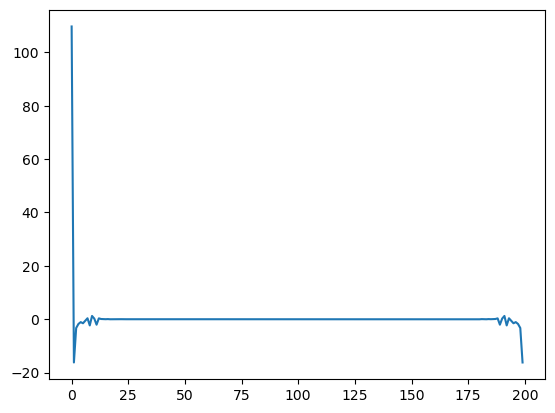

In [29]:
plt.plot(prec_values)

In [30]:
DFT_conv_weight_tsr.shape

torch.Size([1000, 200])

In [31]:
avg_cov_diag

tensor([0.0449, 0.0216, 0.0147, 0.0538, 0.0381, 0.0530, 0.0731, 0.0828, 0.1124,
        0.1705, 0.3428, 1.0045, 0.3428, 0.1705, 0.1124, 0.0828, 0.0731, 0.0530,
        0.0381, 0.0538, 0.0147, 0.0216, 0.0449])

### Test the generation 

In [39]:
K = 15
offsets = th.arange(-K, K+1)
avg_cov_diag = th.zeros(2*K+1)
for k in range(-K, K+1):
    avg_cov_diag[k+K] = th.mean(th.diag(symm_cov_tsr, diagonal=k))

patch_circ_cov = th.zeros(2 * K + 1, 2 * K + 1)
for k in range(-K, K+1):
    for j in range(-K, K+1):
        patch_circ_cov[k+K, j+K] = th.mean(th.diag(symm_cov_tsr, diagonal=j - k)) #avg_cov_diag[j - k + K]

assert th.allclose(patch_circ_cov[:, K], avg_cov_diag)

DFT_conv_weight_col = []
sigma_list = np.logspace(np.log10(0.001), np.log10(100), 1000)
for sigma in sigma_list:
    # solve the linear conv filter 
    conv_weight_ols = th.linalg.solve(patch_circ_cov + sigma ** 2 * th.eye(2 * K + 1), avg_cov_diag)
    conv_weight_pad = th.zeros(N,)
    conv_weight_pad[:2*K+1,] = conv_weight_ols
    conv_weight_pad_shifted = th.roll(conv_weight_pad, shifts=-K)
    # compute the DFT of the conv filter 
    DFT_conv_weight = th.fft.fft(conv_weight_pad_shifted, n=N)
    DFT_conv_weight_col.append(th.real(DFT_conv_weight))
DFT_conv_weight_tsr = th.stack(DFT_conv_weight_col, dim=0)
sigma_tsr = th.tensor(sigma_list, dtype=th.float32)
integrated_DFT = th.trapz(DFT_conv_weight_tsr, sigma_tsr, dim=0)
integrated_amplif = th.trapz(- (1 - DFT_conv_weight_tsr) / sigma_tsr[:, None], sigma_tsr, dim=0) 
# integrate from small sigma to large sigma, the integrated_DFT is the covariance matrix 

cov_values = th.fft.ifft(integrated_DFT, n=N).real
# Count how many values in cov_values are not close to zero
# Define a threshold for what we consider "close to zero"
threshold = 1e-7
non_zero_count = (th.abs(cov_values) > threshold).sum().item()
# Compare with 2K+1
print(f"Number of non-zero elements in cov_values: {non_zero_count}")
print(f"Value of 2K+1: {2*K+1}")

cov_values = th.fft.ifft(integrated_amplif.exp(), n=N).real
threshold = 1e-7
non_zero_count = (th.abs(cov_values) > threshold).sum().item()
# Compare with 2K+1
print(f"Number of non-zero elements in cov_values: {non_zero_count}")
print(f"Value of 2K+1: {2*K+1}")

Number of non-zero elements in cov_values: 31
Value of 2K+1: 31
Number of non-zero elements in cov_values: 57
Value of 2K+1: 31


In [ ]:
# create a GMRF with banded precision matrix
N = 100
precision_matrix = th.zeros(N, N)
# Set main diagonal to 1.0
precision_matrix.diagonal().fill_(1.0)
# Set first diagonal above and below the main diagonal to -0.5
precision_matrix.diagonal(offset=1).fill_(0.5)
precision_matrix.diagonal(offset=-1).fill_(0.5)
precision_matrix.diagonal(offset=2).fill_(0.25)
precision_matrix.diagonal(offset=-2).fill_(0.25)
plt.imshow(precision_matrix)
plt.colorbar()
plt.show()
cov = th.linalg.inv(precision_matrix)
plt.imshow(cov)
plt.colorbar()
plt.show()
# add noise to the GMRF
sigma2 = 0.1
cov_noise = sigma2 * th.eye(N) + cov 
precision_matrix_noise = th.linalg.inv(cov_noise)
plt.imshow(precision_matrix_noise)
plt.colorbar()
plt.show()
# compute the precision matrix
# plot the banded structure
# compute the covariance matrix